# Explore Predictions

In [26]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

## Load Data

Modify data name  
Modify timesteps

In [27]:
####
# MODIFY the time steps as you see fit, you may want to look at the number of points in a day, and choose that 
# Or choose any other time period 
####

TIMESTEP_LIST = [4,6,32, 228]

In [28]:
THRESHOLD_LIST = [0.25, 0.33,0.5,0.75] # THESE ARE PERCENTAGES OF THE MAX MAE, A LOWER PERCENTAGE WILL FIND MORE ANOMALIES

In [29]:

TRAIN_ON_NORMAL = True # IF TRUE THEN REMOVE ROWS THAT HAVE HUMAN FLAGGED ANOMALIES

In [30]:
data_dir = "./"
data_set_1_name = "CEC_compiled_data_5a_updated.csv"
data_set_2_name = "CEC_compiled_data_5b_updated.csv"

In [31]:
data_without_labels = pd.read_csv(data_dir + data_set_1_name)
data_without_labels = data_without_labels.rename(columns={'Anomaly': 'anomaly_by_human'})
data_without_labels.head()

Datetime  ...  anomaly_by_human
0  2020-01-01 07:45:00  ...             False
1  2020-01-01 08:00:00  ...             False
2  2020-01-01 08:15:00  ...             False
3  2020-01-01 08:30:00  ...             False
4  2020-01-01 08:45:00  ...             False

[5 rows x 4 columns]

In [32]:
data_with_labels = pd.read_csv(data_dir + data_set_2_name)
data_with_labels = data_with_labels.rename(columns={'Anomaly': 'anomaly_by_human'})
data_with_labels["anomaly_by_human"] = data_with_labels["anomaly_by_human"].apply(lambda x: str(x))
data_with_labels.head()

Datetime  ...  anomaly_by_human
0  2020-01-01 07:45:00  ...             False
1  2020-01-01 08:00:00  ...             False
2  2020-01-01 08:15:00  ...             False
3  2020-01-01 08:30:00  ...             False
4  2020-01-01 08:45:00  ...             False

[5 rows x 4 columns]

Some datasets have 3 versions (i.e seasonal anomalies not counted)  
Another `pd.read_csv()` call will need to be done here

# Split data into 60-40 train test split

In [33]:
PERCENT_TRAIN = 0.6
train_split_number = int(len(data_with_labels) * PERCENT_TRAIN)

test = data_with_labels.tail(len(data_with_labels) - train_split_number)
if TRAIN_ON_NORMAL:
  train = data_with_labels.head(train_split_number)
  train = train[train["anomaly_by_human"] == "False"]
else:
  train = data_without_labels.head(train_split_number)

# Create sequences of time steps

In [34]:
train["raw_value"] = train["Value"]
test["raw_value"] = test["Value"]

test_raw = test["Value"].copy(deep=True)

scaler = StandardScaler()
scaler = scaler.fit(train[['Value']])

train['Value'] = scaler.transform(train[['Value']])
test['Value'] = scaler.transform(test[['Value']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X)-time_steps+1):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps-1])
    
    return np.array(Xs), np.array(ys)

In [36]:
data_dict = {}

for timestep in TIMESTEP_LIST:
    X_train, y_train = create_sequences(train[['Value']], train['Value'], time_steps=timestep)
    X_test, y_test = create_sequences(test[['Value']], test['Value'], time_steps=timestep)
    data_timestepped = {}
    data_timestepped["x_train"] = X_train
    data_timestepped["y_train"] = y_train
    data_timestepped["x_test"] = X_test
    data_timestepped["y_test"] = y_test
    data_dict[timestep] = data_timestepped


In [37]:
for ts in data_dict.keys():
    print("time step size", ts)
    for _, data_set in data_dict[ts].items():
      print(data_set.shape)
    print("\n")

time step size 4
(24816, 4, 1)
(24816,)
(16552, 4, 1)
(16552,)


time step size 6
(24814, 6, 1)
(24814,)
(16550, 6, 1)
(16550,)


time step size 32
(24788, 32, 1)
(24788,)
(16524, 32, 1)
(16524,)


time step size 228
(24592, 228, 1)
(24592,)
(16328, 228, 1)
(16328,)




In [38]:
test.head()

Datetime    Value  ... anomaly_by_human raw_value
24831  2020-10-09 00:45:00 -1.52202  ...            False       0.0
24832  2020-10-09 01:00:00 -1.52202  ...            False       0.0
24833  2020-10-09 01:15:00 -1.52202  ...            False       0.0
24834  2020-10-09 01:30:00 -1.52202  ...            False       0.0
24835  2020-10-09 01:45:00 -1.52202  ...            False       0.0

[5 rows x 5 columns]

# Step up model

In [39]:
def create_model(x_input):
  model = Sequential()
  model.add(LSTM(128, input_shape=(x_input.shape[1], x_input.shape[2])))
  model.add(Dropout(rate=0.2))
  model.add(RepeatVector(x_input.shape[1]))
  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(rate=0.2))
  model.add(TimeDistributed(Dense(x_input.shape[2])))
  model.compile(optimizer='adam', loss='mae')
  model.summary()
  return model

# Train a Model for Each timestep

In [40]:
for key, inner_data in data_dict.items():
    x_train = inner_data["x_train"]
    y_train = inner_data["y_train"]
    print(x_train.shape)
    print(y_train.shape)
    model = create_model(x_train)
    history = model.fit(x_train, y_train, epochs=100, batch_size=32*4, validation_split=0.1,
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')], shuffle=False)
    inner_data["history"] = history
    inner_data["model"] = model
    model = None

(24816, 4, 1)
(24816,)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 128)            0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 4, 1)              129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________

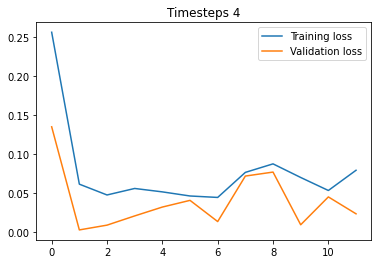

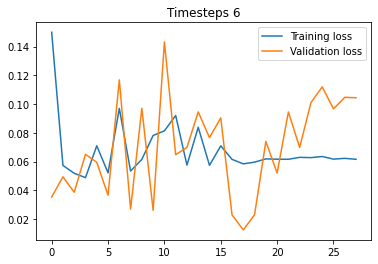

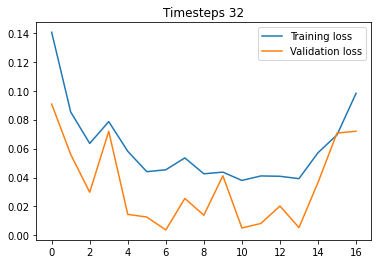

In [41]:
for ts in data_dict.keys():
  history = data_dict[ts]["history"]
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.title("Timesteps {}".format(ts))
  plt.legend();
  plt.show()

In [42]:
for ts in data_dict.keys():
  print("evaluating for timestep: {}".format(ts))
  x_test = data_dict[ts]["x_test"]
  y_test = data_dict[ts]["y_test"]
  model = data_dict[ts]["model"]
  print(model.evaluate(x_test, y_test))

evaluating for timestep: 4
518/518 [==============================] - 1s 3ms/step - loss: 0.0896
0.08957719057798386
evaluating for timestep: 6
518/518 [==============================] - 1s 3ms/step - loss: 0.1054
0.10541129857301712
evaluating for timestep: 32
517/517 [==============================] - 2s 3ms/step - loss: 0.1855
0.18553487956523895
evaluating for timestep: 228
511/511 [==============================] - 5s 10ms/step - loss: 0.0585
0.05848666653037071


In [43]:
for ts in data_dict.keys():
  print("computing info for {}".format(ts))
  model = data_dict[ts]["model"]
  x_train = data_dict[ts]["x_train"]
  y_train = data_dict[ts]["y_train"]
  x_test = data_dict[ts]["x_test"]
  y_test = data_dict[ts]["y_test"]


  x_train_pred = model.predict(x_train, verbose=0)
  train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
  train_score_df = pd.DataFrame(train[ts-1:])
  train_score_df['loss'] = train_mae_loss
  train_score_df['Value'] = train[ts-1:]['Value']
  data_dict[ts]["train_score_df"] = train_score_df

  x_test_pred = model.predict(x_test, verbose=0)
  test_mae_loss = np.mean(np.abs(x_test_pred-x_test), axis=1)
  test_score_df = pd.DataFrame(test[ts-1:])
  test_score_df['loss'] = test_mae_loss
  test_score_df['Value'] = test[ts-1:]['Value']
  data_dict[ts]["test_score_df"] = test_score_df

computing info for 4
computing info for 6
computing info for 32
computing info for 228


Calculates anomalies based on different thresholds, If you want to try different values change `THRESHOLD_LIST` at the top of the notebook, or define it again here with new values

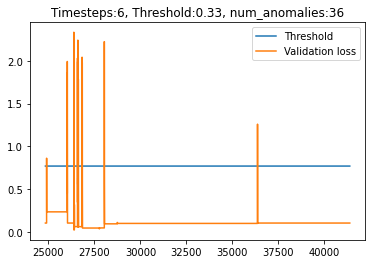

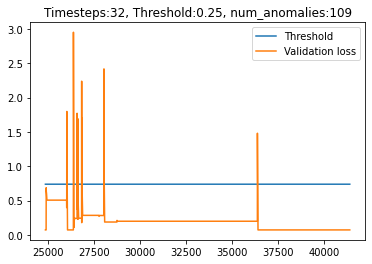

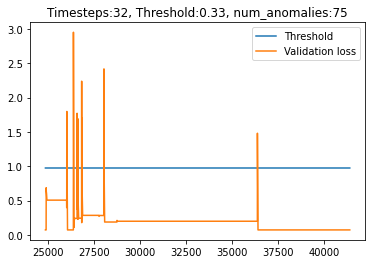

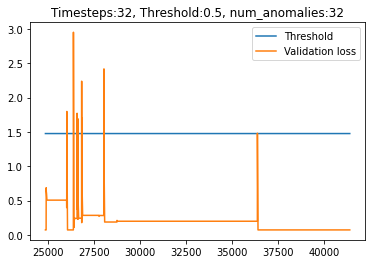

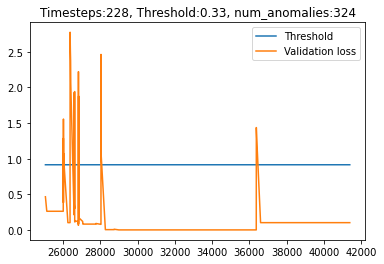

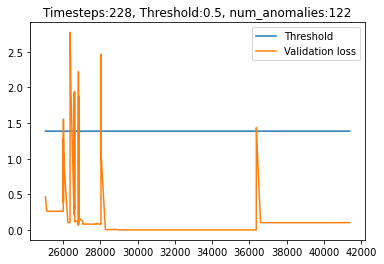

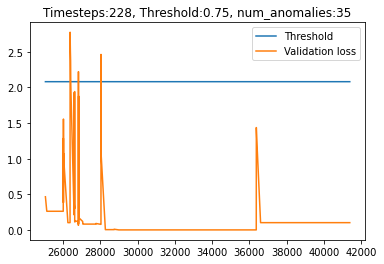

In [44]:
for ts in data_dict.keys():
  for thresh in THRESHOLD_LIST:

    test_score_df = data_dict[ts]["test_score_df"].copy(deep=True)
    max_error = test_score_df["loss"].max()
    threshold = max_error * thresh
    
    test_score_df['threshold'] = threshold
    test_score_df['anomaly_by_machine'] = test_score_df['loss'] > test_score_df['threshold']

    anomalies = test_score_df.loc[test_score_df['anomaly_by_machine'] == True]
    num_anomalies = anomalies.shape[0]

    plt.plot(test_score_df['threshold'], label='Threshold')
    plt.plot(test_score_df['loss'], label='Validation loss')
    plt.title("Timesteps:{}, Threshold:{}, num_anomalies:{}".format(ts, thresh, num_anomalies))
    plt.legend();
    plt.show()

## Trained on Normal Data
![](./images/data_5a_norm_ts_4_thresh_25_a.png)
![](./images/data_5a_norm_ts_4_thresh_25_b.png)
![](./images/data_5a_norm_ts_4_thresh_33_a.png)
![](./images/data_5a_norm_ts_4_thresh_33_b.png)
![](./images/data_5a_norm_ts_6_thresh_25_a.png)
![](./images/data_5a_norm_ts_6_thresh_25_b.png)
![](./images/data_5a_norm_ts_6_thresh_33_a.png)
![](./images/data_5a_norm_ts_6_thresh_33_b.png)

## Trained on All Data

![](./images/data_5a_ts_4_thresh_25_a.png)
![](./images/data_5a_ts_4_thresh_25_b.png)
![](./images/data_5a_ts_4_thresh_33_a.png)
![](./images/data_5a_ts_4_thresh_33_b.png)
![](./images/data_5a_ts_4_thresh_50_a.png)
![](./images/data_5a_ts_4_thresh_50_b.png)
![](./images/data_5a_ts_6_thresh_25_a.png)
![](./images/data_5a_ts_6_thresh_25_b.png)
![](./images/data_5a_ts_6_thresh_33_a.png)
![](./images/data_5a_ts_6_thresh_33_b.png)
![](./images/data_5a_ts_32_thresh_25_a.png)
![](./images/data_5a_ts_32_thresh_25_b.png)
![](./images/data_5a_ts_32_thresh_33_a.png)
![](./images/data_5a_ts_32_thresh_33_b.png)
![](./images/data_5a_ts_228_thresh_25_a.png)
![](./images/data_5a_ts_228_thresh_25_b.png)
![](./images/data_5a_ts_228_thresh_33_a.png)
![](./images/data_5a_ts_228_thresh_33_b.png)

In [45]:
# for ts in data_dict.keys():
#   for thresh in THRESHOLD_LIST[0:2]:

#     test_score_df = data_dict[ts]["test_score_df"].copy(deep=True)
#     max_error = test_score_df["loss"].max()
#     threshold = max_error * thresh
   
#     test_score_df['threshold'] = threshold
#     test_score_df['anomaly_by_machine'] = test_score_df['loss'] > test_score_df['threshold']
#     test_score_df["raw_value"] = test_raw[ts:]
#     test_score_df["anomaly_by_machine_int"] = test_score_df['anomaly_by_machine'].apply(lambda x: str(x))

#     test_score_df["year_month"] = test_score_df["Datetime"].apply(lambda x: "-".join(x.split("-")[0:2]))

    
#     fig = px.scatter(test_score_df, x="Datetime", y="raw_value", color="anomaly_by_machine_int", 
#                      title="Anomalies Detected for Timestep:{}, Threshold:{}".format(ts, thresh))
    
#     human_anomalies = test[test["anomaly_by_human"] == "True"]
   
#     fig.add_trace(go.Scatter(x=human_anomalies["Datetime"], y=human_anomalies["raw_value"], mode="markers",
#                 marker=dict(size=10, color="Black"),
#                 name="anomaly_by_human=True"))

#     fig.show()


In [47]:
# for thresh in THRESHOLD_LIST:
#   for ts in data_dict.keys():

#     test_score_df = data_dict[ts]["test_score_df"].copy(deep=True)
#     max_error = test_score_df["loss"].max()
#     threshold = max_error * thresh
    
#     test_score_df['threshold'] = threshold
#     test_score_df['anomaly_by_machine'] = test_score_df['loss'] > test_score_df['threshold']
#     test_score_df["raw_value"] = test_raw[ts:]
#     test_score_df["anomaly_by_machine_int"] = test_score_df['anomaly_by_machine'].apply(lambda x: str(x))

#     test_score_df["year_month"] = test_score_df["Datetime"].apply(lambda x: "-".join(x.split("-")[0:2]))

    
#     fig = px.scatter(test_score_df, x="Datetime", y="raw_value", color="anomaly_by_machine_int", 
#                      title="Anomalies Detected for Timestep:{}, Threshold:{}".format(ts, thresh))
    
#     human_anomalies = test[test["anomaly_by_human"] == "True"]
    
#     fig.add_trace(go.Scatter(x=human_anomalies["Datetime"], y=human_anomalies["raw_value"], mode="markers",
#                 marker=dict(size=10, color="Black"),
#                 name="anomaly_by_human=True"))

#     fig.show()